CSV Loaded Successfully!
New dataframe shape: (8760, 23)
        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  ...  Functioning Day Day  Month  \
0                      0.0    

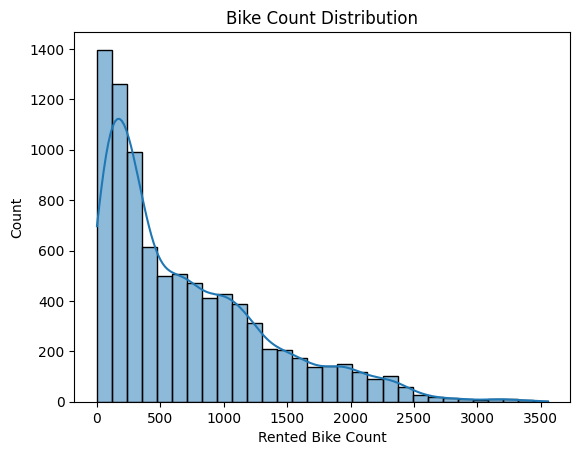

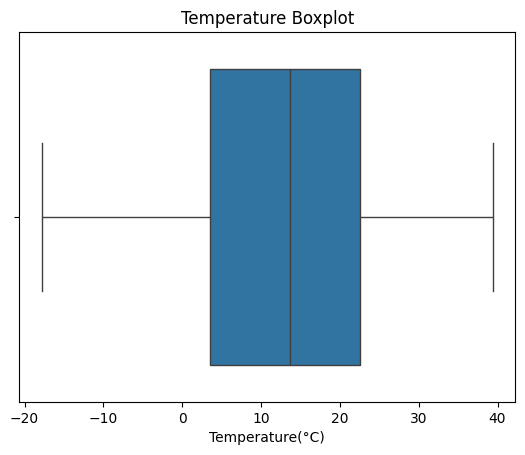


Top Correlations with Rented Bike Count:
Rented Bike Count            1.000000
feels_like_temp              0.579992
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
is_evening_peak              0.361804
Solar Radiation (MJ/m2)      0.261837
Functioning Day              0.203943
Visibility (10m)             0.199280
WeekOfYear                   0.134311
Wind speed (m/s)             0.121108
is_morning_peak             -0.003969
is_weekend                  -0.036467
Holiday                     -0.072338
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
is_low_demand_hour          -0.370501
Name: Rented Bike Count, dtype: float64


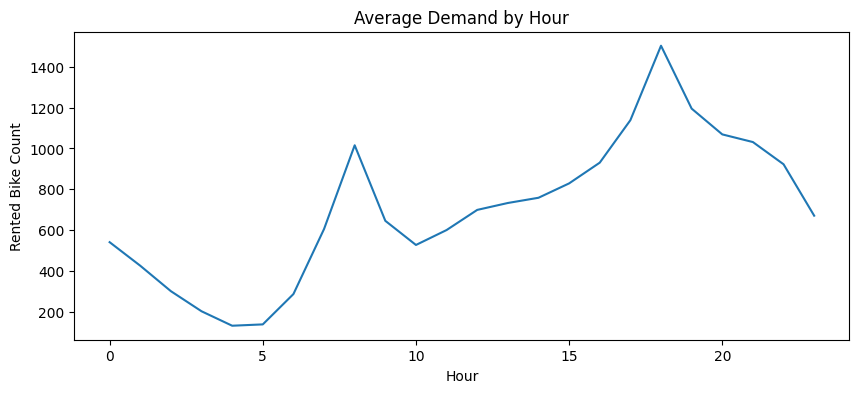

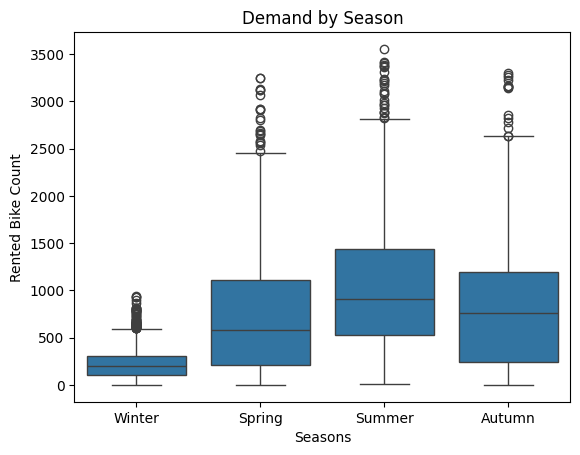


Correlation with Target Variable:
Rented Bike Count            1.000000
feels_like_temp              0.579992
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
is_evening_peak              0.361804
Solar Radiation (MJ/m2)      0.261837
Functioning Day              0.203943
Visibility (10m)             0.199280
WeekOfYear                   0.134311
Month                        0.133514
Wind speed (m/s)             0.121108
Day                          0.022291
is_morning_peak             -0.003969
DayOfWeek                   -0.029357
is_weekend                  -0.036467
Holiday                     -0.072338
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
is_low_demand_hour          -0.370501
Name: Rented Bike Count, dtype: float64


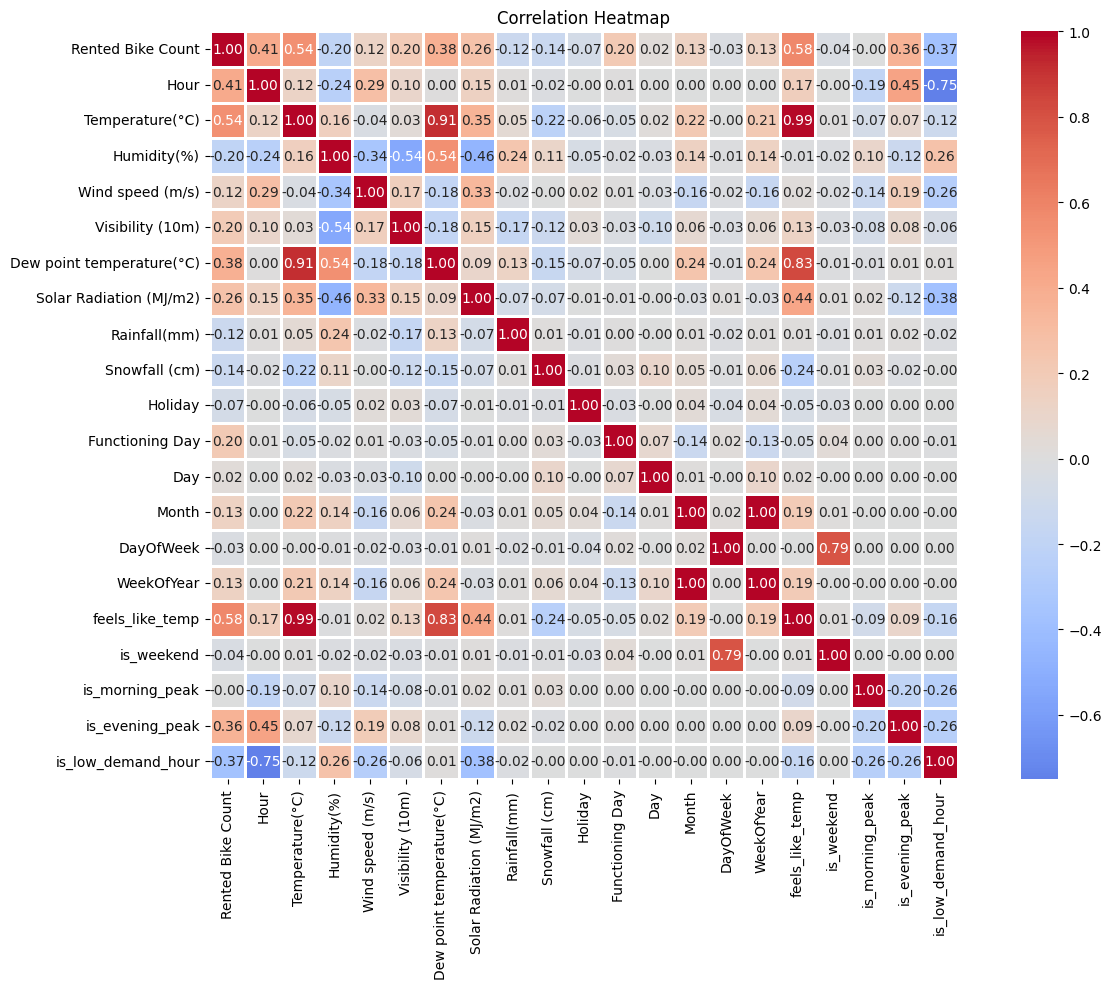

In [ ]:
# ==========================================
# 1. Load Libraries
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 2. Load Dataset from CSV
# ==========================================
df = pd.read_csv('SeoulBikeData.csv', encoding= 'latin1')   # <-- Replace with your file name
print("CSV Loaded Successfully!")
target_col ='Rented Bike Count'

# ==========================================
# 3. Feature Engineering Function
# ==========================================
def add_engineered_features(df):

    # --- Fix Date Column ---
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

    # Extract date parts
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)


    # --- Weather Interaction Features ---
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])

    # --- Flags (Weekend, Peak Hours) ---
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # --- Binary Conversion ---
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    # Drop NaNs created from lags/rolling
    df = df.dropna().reset_index(drop=True)

    return df


# ==========================================
# 4. Apply Feature Engineering
# ==========================================
df = add_engineered_features(df)
print("New dataframe shape:", df.shape)
print(df.head())


# ==========================================
# 5. EDA Section
# ==========================================

# ---- Overview ----
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# ---- Summary ----
print("\nSummary Statistics:")
print(df.describe())

# ---- Outlier Detection ----
def outlier_count(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    return len(outliers)

for col in ['Rented Bike Count','Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']:
    print(f"{col} outliers:", outlier_count(col))

# ---- Distribution ----
sns.histplot(df['Rented Bike Count'], bins=30, kde=True)
plt.title('Bike Count Distribution')
plt.show()

sns.boxplot(x=df['Temperature(°C)'])
plt.title('Temperature Boxplot')
plt.show()

# ---- Correlation Matrix ----
numeric_df = df.select_dtypes(include=['int64','float64'])
corr = numeric_df.corr()

print("\nTop Correlations with Rented Bike Count:")
print(corr['Rented Bike Count'].sort_values(ascending=False))

# ---- Seasonality Plots ----
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df.groupby('Hour')['Rented Bike Count'].mean().reset_index(),
    x='Hour', y='Rented Bike Count'
)
plt.title('Average Demand by Hour')
plt.show()

sns.boxplot(x='Seasons', y='Rented Bike Count', data=df)
plt.title('Demand by Season')
plt.show()

# Correlation matrix
correlation_matrix = df.corr(numeric_only=True)

print("\nCorrelation with Target Variable:")
target_corr = correlation_matrix[target_col].sort_values(ascending=False)
print(target_corr)

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


TFT

In [27]:
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl

from torch.utils.data import DataLoader
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

In [32]:
df = df.sort_values(["Date", "Hour"]).reset_index(drop=True)
df["time_idx"] = np.arange(len(df))
df["series_id"] = 0
df["Seasons"] = df["Seasons"].map({"Winter": 0, "Spring": 1, "Summer": 2, "Autumn": 3})

In [33]:
unique_days = df["Date"].dt.date.unique()
train_days_count = int(len(unique_days) * 0.8)

train_days = unique_days[:train_days_count]
test_days = unique_days[train_days_count:]

train_df = df[df["Date"].dt.date.isin(train_days)]
test_df = df[df["Date"].dt.date.isin(test_days)]

print("Train:", train_df.shape, " Test:", test_df.shape)

Train: (7008, 25)  Test: (1752, 25)


In [37]:

max_encoder_length = 168  # 7 days
max_prediction_length = 24  # 24-hour forecast

training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="Rented Bike Count",
    group_ids=["series_id"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,

    time_varying_known_reals=[
        "Hour", "Month", "DayOfWeek",
        "Holiday", "Functioning Day", "Seasons",
    ],

    time_varying_unknown_reals=[
        "Rented Bike Count",
        "Temperature(°C)", "Humidity(%)", "Wind speed (m/s)",
        "Visibility (10m)", "Dew point temperature(°C)",
        "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)",
         "feels_like_temp", 
        "WeekOfYear", "Day", "is_weekend",
        "is_morning_peak", "is_evening_peak", "is_low_demand_hour"
    ],
)

# Validation set
validation = TimeSeriesDataSet.from_dataset(training, test_df)

# Loaders
batch_size = 128
train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation, batch_size=batch_size)

KeyError: "Unknown category '1786' encountered. Set `add_nan=True` to allow unknown categories"